In [79]:
from pandas import Series, DataFrame
import pandas as pd
import calendar
from patsy import dmatrices
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/shirley/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'cross']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Setup

In [50]:
#read data in, appended 2014/2015, removed GO from col names
crime2014 = pd.read_csv("Austin_Crime_2014.csv", dtype=unicode, encoding='utf-8')
crime2014[:3]

crime2015 = pd.read_csv("Austin_Crime_2015.csv", dtype=unicode, encoding='utf-8')
crime = crime2014.append(crime2015,ignore_index=True)

crime = crime.rename(index=str, columns={"Highest NIBRS/UCR Offense Description": "General Offense Description",\
                                 "GO Highest Offense Desc":"Detailed Offense Description",\
                                 "GO Location":"Location","GO Report Date":"Report Date",\
                                 "GO Location Zip":"Zipcode","GO District":"District","GO Census Tract":"Census Tract",\
                                 "GO X Coordinate":"X Coordinate","GO Y Coordinate":"Y Coordinate",\
                                      "GO Primary Key":"Primary Key"})

crime = crime.drop('Location_1', axis=1)
crime['Date'] = pd.DatetimeIndex(crime['Report Date'])
crime['DayOfWeek'] = pd.DatetimeIndex(crime['Date']).weekday
crime['DayOfWeek'] = crime['DayOfWeek'].apply(lambda x: calendar.day_abbr[x])
crime['Month'] = pd.DatetimeIndex(crime['Date']).month
crime['Month'] = crime['Month'].apply(lambda x: calendar.month_abbr[x])
crime['Year'] = pd.DatetimeIndex(crime['Report Date']).year

crime.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,DayOfWeek,Month,Year
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Thu,Apr,2014
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Fri,Apr,2014
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,Sun,May,2014
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Mon,Jun,2014
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Sat,Jul,2014


## Merge Crimes

In [51]:
def merge_crimes(s):
    """Map some crimes together."""
    
    # Create a map of misspellings to correct spelling
    misspellings = {'Burglary / \nBreaking & Entering':'Burglary',
                    'Auto Theft':'Theft: Auto Parts',
                    'Homicide: Murder & Nonnegligent Manslaughter':'Murder',
                    'Agg Assault':'Aggravated Assault'}
    
    if s in misspellings:
        return misspellings[s]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_crimes)

def merge_theft(s):
    """Map some crimes together."""
    
    if (s[:5]=='Theft'):
        return s[:5]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_theft)

# Check that it worked
# mask = (crime['General Offense Description'] == 'Agg Assault')
# crime['General Offense Description'][mask]  # should be empty

crime['General Offense Description'].value_counts()

Theft                 61908
Burglary              10597
Aggravated Assault     3803
Robbery                1809
Rape                   1042
Murder                   55
Name: General Offense Description, dtype: int64

In [61]:
crime['Streetname'] = crime['Location'].str.rsplit('\n', -1).str[0].str.replace('^[/\s\d-]+/?\d*\s+', '').str.replace('^\d+[A-Z]\s+', '').str.replace('^BLOCK\s+', '').str.replace('\s[NSEW]B\s*$', '').str.replace('\sSVRD\s*$', '').str.replace('^\s*[NSEW]\s+', '').str.replace(' HALF ST', ' ST').str.rstrip()
crime['PrimaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[0]
crime['SecondaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[1]

In [66]:
df = crime[['Zipcode', 'Month', 'DayOfWeek']]

# Final Dataframe

In [63]:
df.head()

,Zipcode,Month,DayOfWeek
0,78753,Apr,Thu
1,78723,Apr,Fri
2,78702,May,Sun
3,78723,Jun,Mon
4,78702,Jul,Sat


## Example Stacked Graph

Total crime count: 8491


Theft                 7243
Burglary               598
Aggravated Assault     300
Robbery                206
Rape                   141
Murder                   3
Name: General Offense Description, dtype: int64


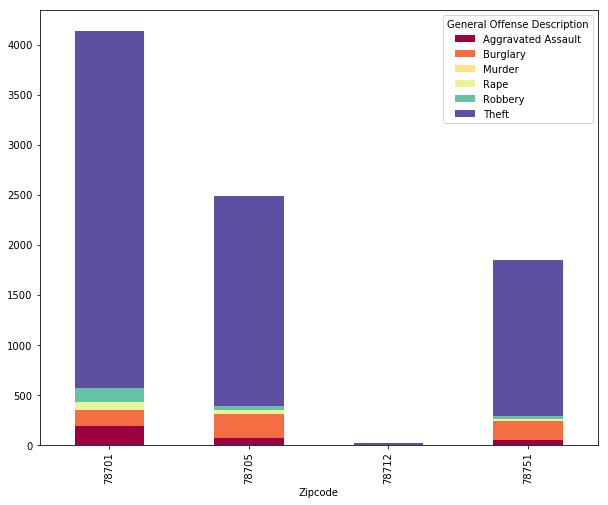

In [53]:
crime_wc = crime['Zipcode']=="78705"
crime_ut = crime['Zipcode']=="78712"
crime_hyde = crime['Zipcode']=="78751"
crime_dt = crime['Zipcode']=="78701"
area_mask = crime_wc | crime_ut | crime_hyde | crime_dt

#print(area_mask)

crime_student = crime[area_mask]

pylab.rcParams['figure.figsize'] = (10, 8)

campus = crime_student.groupby(['Zipcode', 'General Offense Description'])['Zipcode'].count().unstack('General Offense Description').fillna(0)
campus.plot(kind='bar', stacked=True, colormap='Spectral')


# total crime count
print "Total crime count:", crime_student['General Offense Description'].count()

# crime split into offenses
crime_student_vc = crime_student['General Offense Description'].value_counts()
print "\n"
print(crime_student_vc)
#crime_student_vc.plot(kind='bar')


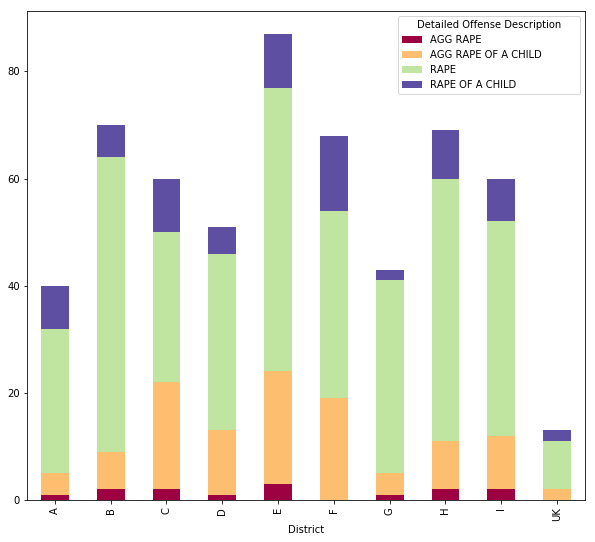

In [49]:
pylab.rcParams['figure.figsize'] = (10, 9)

theft_mask = crime['General Offense Description']=='Rape'
crime_specific = crime[theft_mask & mask_2014]
crime_specific.head()

crime_specific = crime_specific.groupby(['District', 'Detailed Offense Description'])['District'].count().unstack('Detailed Offense Description').fillna(0)
crime_specific.plot(kind='bar', stacked=True, colormap='Spectral')



In [76]:
df = crime
result = pd.crosstab(df['DayOfWeek'], [df['Month'], df['Zipcode']], dropna=False)
result

Month       Apr                                                        ...   \
Zipcode   78610 78613 78617 78652 78653 78660 78701 78702 78703 78704  ...    
DayOfWeek                                                              ...    
Fri           0     8    10     0     0     1    24    40    15    55  ...    
Mon           0     6     5     0     0     7    55    53    23    59  ...    
Sat           0     9    11     0     0     3    36    33     5    41  ...    
Sun           0     5     6     0     0     1    51    38    11    49  ...    
Thu           0     4     9     0     2     1    34    40    24    59  ...    
Tue           0    10     7     0     2     5    39    51    22    69  ...    
Wed           0    11     6     0     0     3    46    56    26    76  ...    

Month       Sep                                                        
Zipcode   78749 78750 78751 78752 78753 78754 78756 78757 78758 78759  
DayOfWeek                                                              
Fri          12     6    13    25    88     7    12    35    72    41  
Mon          18    17    13    32   118    13    13    20    61    40  
Sat          18     8    17    27    70     1     5    22    47    23  
Sun          18     3     9    24    70     4     2    17    32    16  
Thu          18    14    20    28    76    11     7    29    65    41  
Tue          23    17    31    40   103    11    14    27    70    33  
Wed          17     8    30    34    87     7     9    29    85    42  

[7 rows x 576 columns]

In [77]:
df = crime.drop_duplicates(subset='Date')
test = pd.crosstab(df['DayOfWeek'], [df['Month']], dropna=False)
test

Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
DayOfWeek,,,,,,,,,,,,
Fri,8,9,8,8,10,9,8,8,10,8,10,8
Mon,8,9,9,8,8,8,10,10,8,9,8,9
Sat,8,10,8,8,9,8,8,9,10,9,9,8
Sun,8,10,8,8,8,8,9,10,9,10,8,8
Thu,9,8,9,8,10,10,8,8,9,8,10,8
Tue,9,8,10,8,8,9,9,9,8,8,8,10
Wed,10,8,10,8,9,10,8,8,8,8,9,9


In [78]:
final = pd.DataFrame((result/test).unstack()).reset_index()
final.columns = ['Month', 'Zipcode', 'Day', 'Average']
final

,Month,Zipcode,Day,Average
0,Apr,78610,Fri,0.000000
1,Apr,78610,Mon,0.000000
2,Apr,78610,Sat,0.000000
3,Apr,78610,Sun,0.000000
4,Apr,78610,Thu,0.000000
5,Apr,78610,Tue,0.000000
6,Apr,78610,Wed,0.000000
7,Apr,78613,Fri,1.000000
8,Apr,78613,Mon,0.750000
9,Apr,78613,Sat,1.125000


In [80]:
y, X = dmatrices('Average ~ Month + Zipcode + Day', data=final, return_type='dataframe')

In [81]:
import statsmodels.api as sm
model = sm.OLS(y, X)
result = model.fit()
print result.summary()

/Users/shirley/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     817.2
Date:                Sun, 13 Aug 2017   Prob (F-statistic):               0.00
Time:                        11:43:25   Log-Likelihood:                -4383.2
No. Observations:                4032   AIC:                             8896.
Df Residuals:                    3967   BIC:                             9306.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0364      0.092  

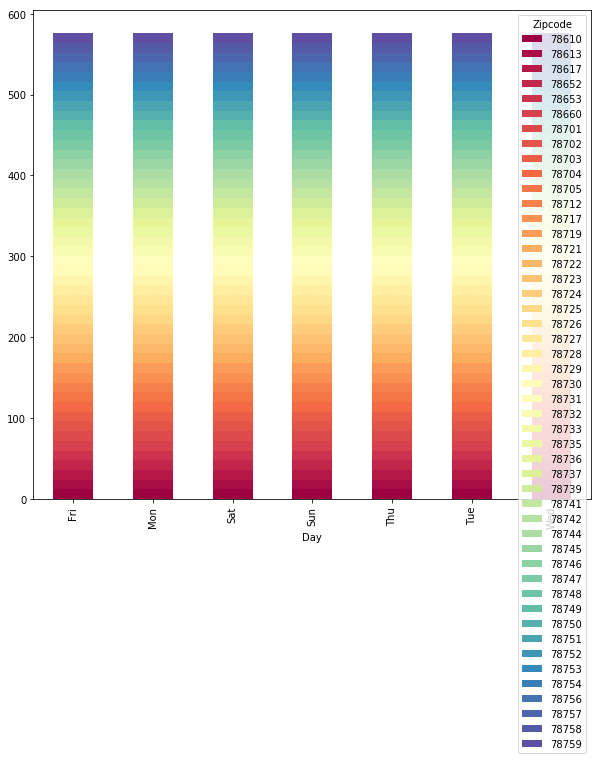

In [85]:
pylab.rcParams['figure.figsize'] = (10, 9)

final_zip = final
final_zip = final_zip.groupby(['Day', 'Zipcode'])['Day'].count().unstack('Zipcode').fillna(0)
final_zip.plot(kind='bar', stacked=True, colormap='Spectral')